We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, roc_curve, roc_auc_score

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Stroke EDA.

In [2]:
### DATA PREPARATION
stroke = pd.read_csv('C:\\Users\\Shekhar Lamba\\Documents\\Datasets\\healthcare-dataset-stroke-data.csv', na_values = [np.NaN, ' '])

df = pd.DataFrame(stroke)
df = df.drop(['id'], axis = 1)

num_vars = df.select_dtypes(include = ['int64', 'float64'])
cat_vars = df.select_dtypes(include = 'object')
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]

mean_imputer = SimpleImputer(strategy = 'mean')
imputed_vars = mean_imputer.fit_transform(num_vars)
df_imputed = pd.DataFrame(np.hstack([imputed_vars, cat_vars]), columns = feature_names)

df_imputed['age'] = df_imputed['age'].astype('float64')
df_imputed['hypertension'] = df_imputed['hypertension'].astype('int64')
df_imputed['heart_disease'] = df_imputed['heart_disease'].astype('int64')
df_imputed['avg_glucose_level'] = df_imputed['avg_glucose_level'].astype('float64')
df_imputed['bmi'] = df_imputed['bmi'].astype('float64')
df_imputed['stroke'] = df_imputed['stroke'].astype('int64')

capping = num_vars.select_dtypes(include = 'float64')
for col in df_imputed.columns:
    if col in capping.columns:
        percentile = df_imputed[col].quantile([0.05, 0.95]).values
        df_imputed[col] = df_imputed[col].clip(lower = percentile[0], upper = percentile[1])
        
df_final = pd.get_dummies(df_imputed, columns = ['gender', 'ever_married', 'work_type', 'Residence_type',
                                              'smoking_status'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of people who did not suffer from stroke and those who did.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['stroke'], axis = 1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 99)

We now go on to make a simple XGBoost model, which will serve as our baseline. Remember that the data was highly unbalanced in that the number of people who did not suffer from stroke was far more than those who did. Unlike other ML methods, in XGBoost this issue is addressed during the process of hyperparameter tuning. As for now, we shall build a baseline model on the unbalanced data.

Few things to keep in mind here are the learning objective, which we set as binary and logistic since we are performing binary classification. Also, fitting the model to the training data requires specifying a few parameters: 

1. early_stopping_rounds: terminates the training process if the metric on the evaluation set doesnt improve after said rounds
2. eval_metric: the metric to be considered for early stopping
3. eval_set: the evaluation set to be considered for early stopping

So, we build the model, fit it to the training data and plot the confusion matrix.

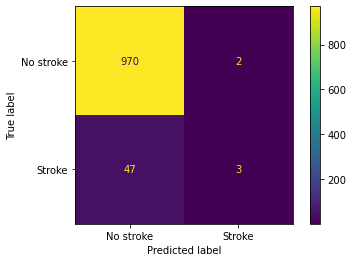

In [4]:
### CREATING A BASELINE MODEL
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed = 99, use_label_encoder = False)
clf_xgb.fit(X_train,
           y_train,
           early_stopping_rounds = 20,
           verbose = False,
           eval_metric = 'aucpr',
           eval_set = [(X_test, y_test)])
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Before we proceed, let us first take a look at the distribution of the levels of y in our dataset.

In [5]:
df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Here, we see that around 95% of the people in our dataset have not suffered from stroke as opposed to just about 5% who actually have. This means that even if our model predicts every person as not having a stroke, the model will still be 95% accurate at the very least. So, in this case, accuracy is a deceptive metric.

What we should rather be concerned with is the number of people who actually had stroke but were not identified by the model as having stroke i.e. the False Negatives. Lower the FN value, lower is the risk of overlooking a possible case of stroke and thus better is the model because the main objective of the model here should be to possibly save lives by correctly identifying a stroke case as early as possible. To reduce the FN value, we need to ensure that the recall of stroke cases is high since recall and FN are inversely proportional.

So, we shall calculate the accuracy, recall score and oob error for the predictions made by the model.

In [6]:
### CALCULATING ESSENTIAL METRICS
y_pred_xgb = clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_xgb))
print('Recall score: %f' % recall_score(y_test, y_pred_xgb))

              precision    recall  f1-score   support

   No stroke       0.95      1.00      0.98       972
      Stroke       0.60      0.06      0.11        50

    accuracy                           0.95      1022
   macro avg       0.78      0.53      0.54      1022
weighted avg       0.94      0.95      0.93      1022

Accuracy: 0.952055
Recall score: 0.060000


If we look at the confusion matrix, we see that out of the 50 cases that had actually suffered from stroke, only 3 were correctly predicted as having a stroke by our model. The baseline simply predicted almost all of the stroke cases as not having a stroke. This gives us a recall score of just 6% while the accuracy is about 95%. Even though we have achieved great accuracy, the model is very poor. However, this might be due to the severe imbalance in the dataset.

Next, we plot the ROC curve and calculate the AUC score.

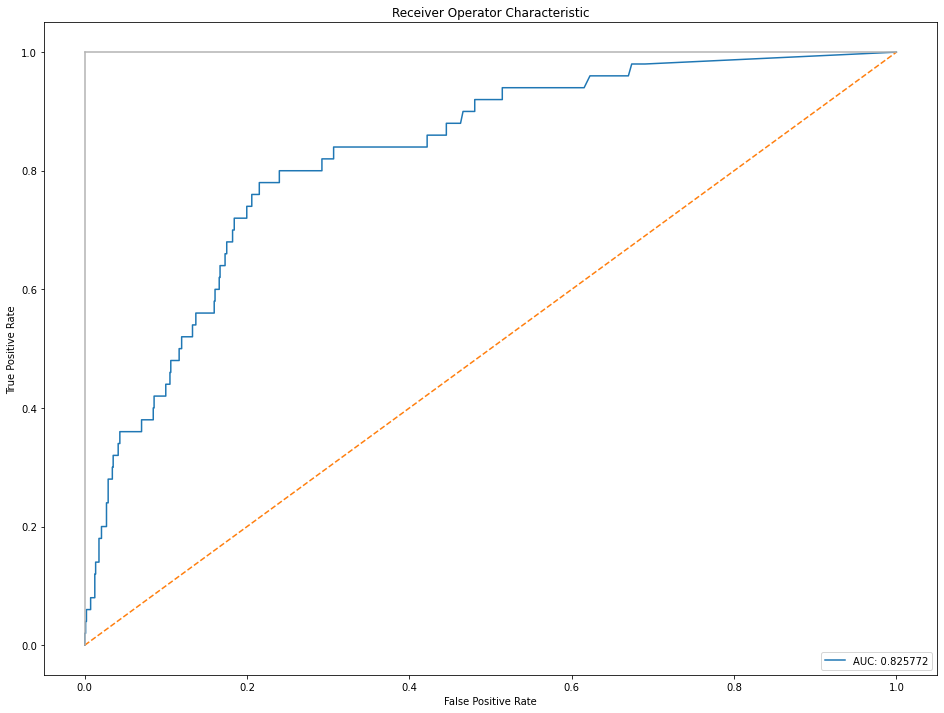

In [7]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_xgb = clf_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_xgb)
roc_auc = roc_auc_score(y_test, y_prob_xgb)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.8258. The high score is probably due to the model correctly predicting all the non-stroke cases. Thus, the baseline is a very poor model though again, this might be due to the currently unaddressed imbalance in the dataset.


Next, we will try to improve the model by tuning it's hyperparameters. For this, we shall use a random search with 10 fold cross-validation across the possible values for the following hyperparameters:
1. learning_rate: it reduces the effect of individual trees thereby decreasing overfitting
2. max_depth: the maximum number of levels in each tree 
3. min_child_weight: the minimum sum of the weights of all samples in a node required in order to make further splits
4. gamma: the minimum loss reduction required to make further splits
5. subsample: percent of the total samples to be considered while building each tree
6. colsample_bytree: percent of the total features to be considered while building each tree
7. scale_pos_weight: this is the hyperparameter that manages the imbalance in our dataset by controlling the balance in weights of the two classes
8. reg_lambda: L2 regularization term on weights
9. reg_alpha: L1 regularization term on weights

As we are trying to decrease the FN value, we will use roc_auc as our scoring parameter.

In [8]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
param_distributions_1 = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': range(3, 10),
    'min_child_weight': range(1, 6),
    'gamma': [i/10 for i in range(0, 10)],
    'subsample': [i/100 for i in range(60, 90, 5)],
    'colsample_bytree': [i/100 for i in range(60, 90, 5)],
    'scale_pos_weight': range(1, 100, 2),
    'reg_lambda': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20],
    'reg_alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20]
}
xg = xgb.XGBClassifier(objective = 'binary:logistic', seed = 99, use_label_encoder = False)
random_fit_1 = RandomizedSearchCV(estimator = xg,
                                 param_distributions = param_distributions_1,
                                 scoring = 'roc_auc',
                                 cv = 10,
                                 n_iter = 30,
                                 random_state = 99,
                                 verbose = 2,
                                 n_jobs = -1)
random_fit_1.fit(X_train,
                y_train,
                early_stopping_rounds = 20,
                verbose = False,
                eval_metric = 'aucpr',
                eval_set = [(X_test, y_test)])
print(random_fit_1.best_params_)
print('Best score: %f' % random_fit_1.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   38.7s finished


{'subsample': 0.65, 'scale_pos_weight': 27, 'reg_lambda': 0.005, 'reg_alpha': 0.0001, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.001, 'gamma': 0.5, 'colsample_bytree': 0.75}
Best score: 0.839612


Now, with these tuned hyperparameter values, we shall create our final XGBoost model.

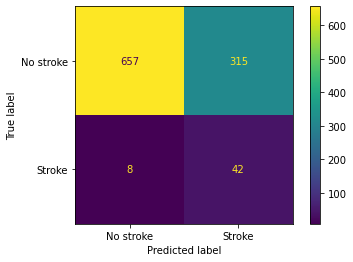

In [9]:
### CREATING THE FINAL MODEL
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', 
                            learning_rate = 0.001,
                            max_depth = 4,
                            min_child_weight = 3,
                            gamma = 0.5,
                            subsample = 0.65,
                            colsample_bytree = 0.75,
                            scale_pos_weight = 27,
                            reg_lambda = 0.005,
                            reg_alpha = 0.0001,
                            seed = 99, 
                            use_label_encoder = False)
clf_xgb.fit(X_train,
           y_train,
           early_stopping_rounds = 20,
           verbose = False,
           eval_metric = 'aucpr',
           eval_set = [(X_test, y_test)])
plot_confusion_matrix(clf_xgb, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, the final model predicts 42 correctly while it fails to do the same for the other 8. This is much better than our baseline model.

In [10]:
### CALCULATING ESSENTIAL METRICS
y_pred_xgb = clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_xgb))
print('Recall score: %f' % recall_score(y_test, y_pred_xgb))

              precision    recall  f1-score   support

   No stroke       0.99      0.68      0.80       972
      Stroke       0.12      0.84      0.21        50

    accuracy                           0.68      1022
   macro avg       0.55      0.76      0.50      1022
weighted avg       0.95      0.68      0.77      1022

Accuracy: 0.683953
Recall score: 0.840000


The recall score gone up to 84% while the accuracy has reduced to about 68%, pointing to the already established fact that accuracy is a deceptive metric in this case.

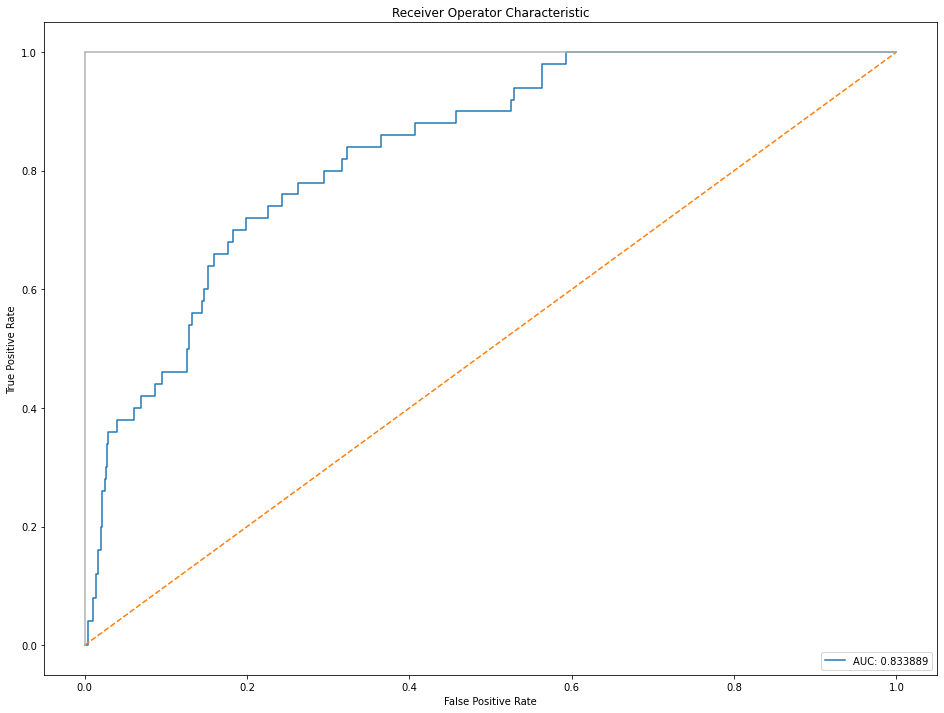

In [11]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_xgb = clf_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_xgb)
roc_auc = roc_auc_score(y_test, y_prob_xgb)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.8283, which is more than it's predecessor. This further proves our case for the final model being than the baseline model.